In [48]:
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import graphviz
from graphviz import Digraph
#https://stackoverflow.com/questions/52472611/how-do-i-make-sure-the-graphviz-executables-are-on-my-systems-path
os.environ["PATH"] += os.pathsep + r'C:/Program Files/Graphviz/bin/'
%matplotlib inline

In [49]:
def f(x):
    return 3*x**2 - 4*x + 5

In [50]:
f(3.0)

20.0

In [51]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

In [52]:
h = 0.001
x = -3.0
(f(x + h) - f(x))/h

-21.996999999998934

In [53]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
d

4.0

In [54]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('slope',(d2 - d1)/h)

slope -3.000000000010772


In [55]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('slope',(d2 - d1)/h)

slope 2.0000000000042206


In [56]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('slope',(d2 - d1)/h)

slope 0.9999999999976694


Building the Value Object

In [57]:
class Value:
    def __init__(self,data):
        self.data = data
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        out = Value(self.data + other.data)
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data)
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10)
a + b
a * b
a*b + c

Value(data=4.0)

The above implementation cannot maintain a computation graph. Hence its required that each node/value keep track of which values hold data and connected to it

In [58]:
class Value:
    #when we create a single values Value object, we dont
    #pass in any children, however when we do an operation
    #we pass in the associated objects to be held as children
    def __init__(self,data,_children = ()):
        #the input will be a tuple of children
        #but the data will be held as a Set
        #done for efficiency
        self.data = data
        self._prev = set(_children)
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        out = Value(self.data + other.data,_children = (self,other))
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data,_children = (self,other))
        return out
    
a = Value(2.0)
b = Value(-3.0)
c = Value(10)
a + b
a * b
#a*b results in a Value object with _prev
#The object from a*b is fed into the addition method
#and the final object will also have a _prev
d = a*b + c
d

Value(data=4.0)

In [59]:
d._prev

{Value(data=-6.0), Value(data=10)}

Currently we still dont know which operation created the d value

In [66]:
class Value:
    #when we create a single values Value object, we dont
    #pass in any children, however when we do an operation
    #we pass in the associated objects to be held as children
    def __init__(self,data,_children = (),_op = '',label = ''):
        #the input will be a tuple of children
        #but the data will be held as a Set
        #done for efficiency
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        out = Value(self.data + other.data,_children = (self,other),_op = '+')
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data,_children = (self,other),_op = '*')
        return out

a = Value(2.0,label = 'a')
b = Value(-3.0,label = 'b')
c = Value(10,label = 'c')
d = Value(14,label = 'd')
e = Value(-6.0,label = 'e')
f = Value(1.0,label = 'f')
g = Value(10,label='g')
a + b
a * b
h = a*b + c*d + f*e
i = h + g
i


Value(data=138.0)

In [69]:
h._prev

{Value(data=-6.0), Value(data=134.0)}

The above expressions are simple. But they get large very fast. Hence we need a way to visualize these functions. 

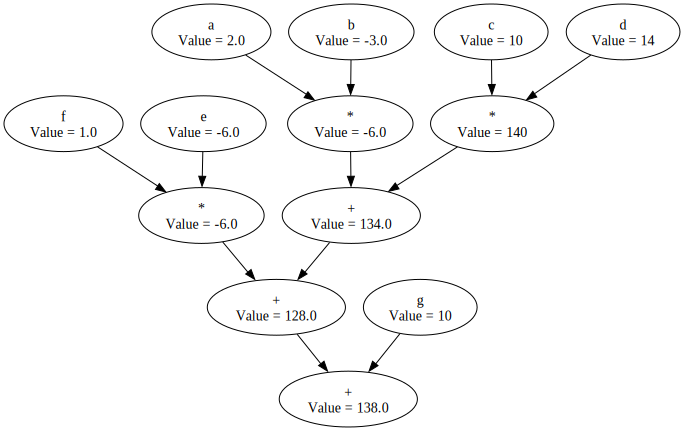

In [68]:
def trace(root):
    nodes,edges = set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
        for i in v._prev:
            edges.add((v,i,v._op))
            build(i)
    build(root)
    return nodes,edges

def obtain_label(edge):
    key_names = {'child_name':None,
                 'parent_name':None,
                 'operation':None}
    child = edge[1]
    parent = edge[0]
    op = edge[2]
    if child.label == '':
        key_names['child_name'] = f"{child._op} \n Value = {child.data}"
    else:
        key_names['child_name'] = child.label
    if parent.label == '':
        key_names['parent_name'] = f"{parent._op} \n Value = {parent.data}"
    else:
        key_names['parent_name'] = parent.label
    key_names['operation'] = op
    return key_names




def build_graph(root):
    nodes,edges = trace(root)
    dot = graphviz.Digraph('computation_graph')
    # id_node_dict = {}
    for node in nodes:
        if node.label != '':
            uid = str(id(node))
            dot.node(uid,label = f"{node.label} \n Value = {node.data}")
        else:
            #this means its a result of an operation
            uid = str(id(node))
            dot.node(uid,label = f"{node._op} \n Value = {node.data}")
    for edge in edges:
        # required_data = obtain_label(edge)
        # dot.edge(required_data['child_name'],required_data['parent_name'])
        dot.edge(str(id(edge[1])),str(id(edge[0])))
    return dot

build_graph(i)